In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
device_name = tf.test.gpu_device_name()

In [2]:
tf.VERSION

'1.15.0'

In [3]:
device_name

'/device:GPU:0'

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/ColabTrain/Data/data.zip' 'data.zip'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE + (3,),
                                               include_top=False,
                                               weights='imagenet')

In [9]:
%ldir

drwx------ 4 root      4096 Oct 26 19:50 gdrive/
drwxr-xr-x 1 root      4096 Oct 22 15:18 sample_data/


In [0]:
!unzip data.zip

In [0]:
train_data = 'train'
test_data = 'validation'

In [14]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_image_data = train_image_generator.flow_from_directory(train_data, target_size=IMG_SHAPE)
test_image_data = test_image_generator.flow_from_directory(test_data, target_size=IMG_SHAPE)

Found 114914 images belonging to 23 classes.
Found 34437 images belonging to 23 classes.


In [15]:
img_batch = None
for image_batch, label_batch in train_image_data:
    img_batch = image_batch
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 23)


In [0]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
feature_batch = base_model(img_batch)

In [19]:
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
feature_batch_max = global_max_layer(feature_batch)
feature_batch_max.shape

TensorShape([Dimension(32), Dimension(1280)])

In [20]:
prediction_layer = layers.Dense(train_image_data.num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_max)
prediction_batch.shape

TensorShape([Dimension(32), Dimension(23)])

In [0]:
model = tf.keras.Sequential([
  base_model,
  global_max_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
%ldir

drwx------  4 root      4096 Oct 26 19:50 gdrive/
drwxr-xr-x  1 root      4096 Oct 22 15:18 sample_data/
drwxrwxr-x 25 root      4096 Oct 26 19:02 train/
drwxr-xr-x 25 root      4096 Oct 26 19:10 validation/


In [0]:
full_path = 'gdrive/My Drive/ColabTrain/'

In [0]:
# checkpoint
filepath= full_path + "checkpoints/check-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, target='max')

In [28]:
EPOCHS = 5
steps_per_epoch = np.ceil(train_image_data.samples/train_image_data.batch_size)
validation_steps = np.ceil(test_image_data.samples/test_image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_image_data,
                              validation_data=test_image_data,
                              validation_steps=validation_steps,
                              epochs=EPOCHS,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback, checkpoint])

Epoch 1/5
1077/3592 [=======>......................] - ETA: 3:40 - loss: 5.7862 - acc: 0.3095
Epoch 00001: acc improved from -inf to 0.78125, saving model to gdrive/My Drive/ColabTrain/checkpoints/check-01-0.78.hdf5
3592/3592 [==============================] - 473s 132ms/step - loss: 1.2068 - acc: 0.7812 - val_loss: 5.7862 - val_acc: 0.3095
Epoch 2/5
1076/3592 [=======>......................] - ETA: 3:36 - loss: 5.5919 - acc: 0.3340
Epoch 00002: acc improved from 0.78125 to 0.96875, saving model to gdrive/My Drive/ColabTrain/checkpoints/check-02-0.97.hdf5
3592/3592 [==============================] - 461s 128ms/step - loss: 0.8067 - acc: 0.9688 - val_loss: 5.5979 - val_acc: 0.3340
Epoch 3/5
1076/3592 [=======>......................] - ETA: 3:36 - loss: 6.9837 - acc: 0.3188
Epoch 00003: acc did not improve from 0.96875
3592/3592 [==============================] - 460s 128ms/step - loss: 0.7852 - acc: 0.9375 - val_loss: 6.9886 - val_acc: 0.3188
Epoch 4/5
1076/3592 [=======>...............

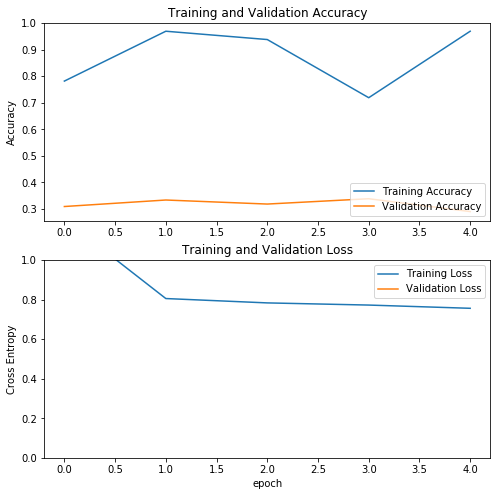

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.save(full_path + 'saved_models/' + 'validated_5e.h5')

In [32]:
tf.saved_model.save(model, full_path + 'saved_models/' + 'validated_5e/')

INFO:tensorflow:Assets written to: gdrive/My Drive/ColabTrain/saved_models/validated_5e/assets


In [0]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

In [0]:
label_id = np.argmax(label_batch, axis=-1)


In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title() + ' ' + str(predicted_id[n]), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
reloaded = tf.keras.models.load_model(full_path + 'checkpoints/weights-improvement-03-0.91.hdf5')
model = reloaded

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
